# Random forest, SVM, decision tree, Adaboost, GradientBoosting, KNN & SMOTE

In [24]:
# Importer les bibliothèques
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import cross_val_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

In [17]:
#!pip install nb-black
from sklearn.preprocessing import StandardScaler

In [18]:
# importer la base de données
# index_col="Date/Heure",parse_dates=True, pour indique que la colonne date/heur est l'index de type date
db = pd.read_csv(
    "ToutFenetresPlanningVol_10_15min.csv",
    index_col="Date/Heure",
    parse_dates=True,
    sep=";",
    encoding="ISO-8859-1",
)

In [19]:
db = db.iloc[1:]  # supprimer la 1 ere ligne des unités
db = (db.stack().str.replace(",", ".").unstack()
)  # remplacer la virgule par un point :decimal
db.iloc[:, :] = db.iloc[:, :].astype(float)  # convertir string to float
# db.info()

In [22]:
# importer la base de données
db = pd.read_csv("ToutFenetresPlanningVol_10_15min.csv", sep=";", encoding="ISO-8859-1")

db = db.stack().str.replace(",", ".").unstack()
# db_Meteo=db_Meteo.stack().str.replace(',','.').unstack()
# db1=pd.merge(db_Meteo,db, on='Date/Heure')

db1 = db.drop(["Date/Heure"], axis=1)
db_date = db["Date/Heure"]
db1 = db1.iloc[1:]
db1.iloc[:, :] = db1.iloc[:, :].astype(float)
db=db1.iloc[:,[2,3,6,7,9,12,15,0]]

In [23]:
db

,Vent. externe,Chauffage de zone,Occupation,Apports solaires Fenêtres extérieures,Température d'air,Electricité pour la zone,Température Sèche Air Extérieur,Vent Méca + Vent Nat Ext + Infiltration
1,0.0,0.0,0.0,0.0,15.85499,0.114429,5.525,0.725876
2,0.0,0.0,0.0,0.0,15.65203,0.114429,4.650,0.727599
3,0.0,0.0,0.0,0.0,15.42231,0.114429,3.775,0.729278
4,0.0,0.0,0.0,0.0,15.19036,0.114429,2.900,0.730974
5,0.0,0.0,0.0,0.0,15.06030,0.114429,3.250,0.729776
...,...,...,...,...,...,...,...,...
35036,0.0,0.0,0.0,0.0,13.01602,0.114429,0.100,0.733118
35037,0.0,0.0,0.0,0.0,12.94014,0.114429,0.425,0.732068
35038,0.0,0.0,0.0,0.0,12.88162,0.114429,0.750,0.731063
35039,0.0,0.0,0.0,0.0,12.83418,0.114429,1.075,0.730088


In [12]:
# Creation du modele (parntèse à ne pas oublier dans linear_model.LinearRegression() si non erreur dans la methode fit )
db["Vent. externe"] = db["Vent. externe"].astype(int)

<ipython-input-12-a20bf55107ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["Vent. externe"] = db["Vent. externe"].astype(int)


In [13]:
db[db["Vent. externe"] != 0]["Vent. externe"].shape

(147,)

In [14]:
db.columns

Index(['Vent. externe', 'Chauffage de zone', 'Occupation',
       'Apports solaires Fenêtres extérieures', 'Température d'air',
       'Electricité pour la zone', 'Température Sèche Air Extérieur',
       'Vent Méca + Vent Nat Ext + Infiltration'],
      dtype='object')

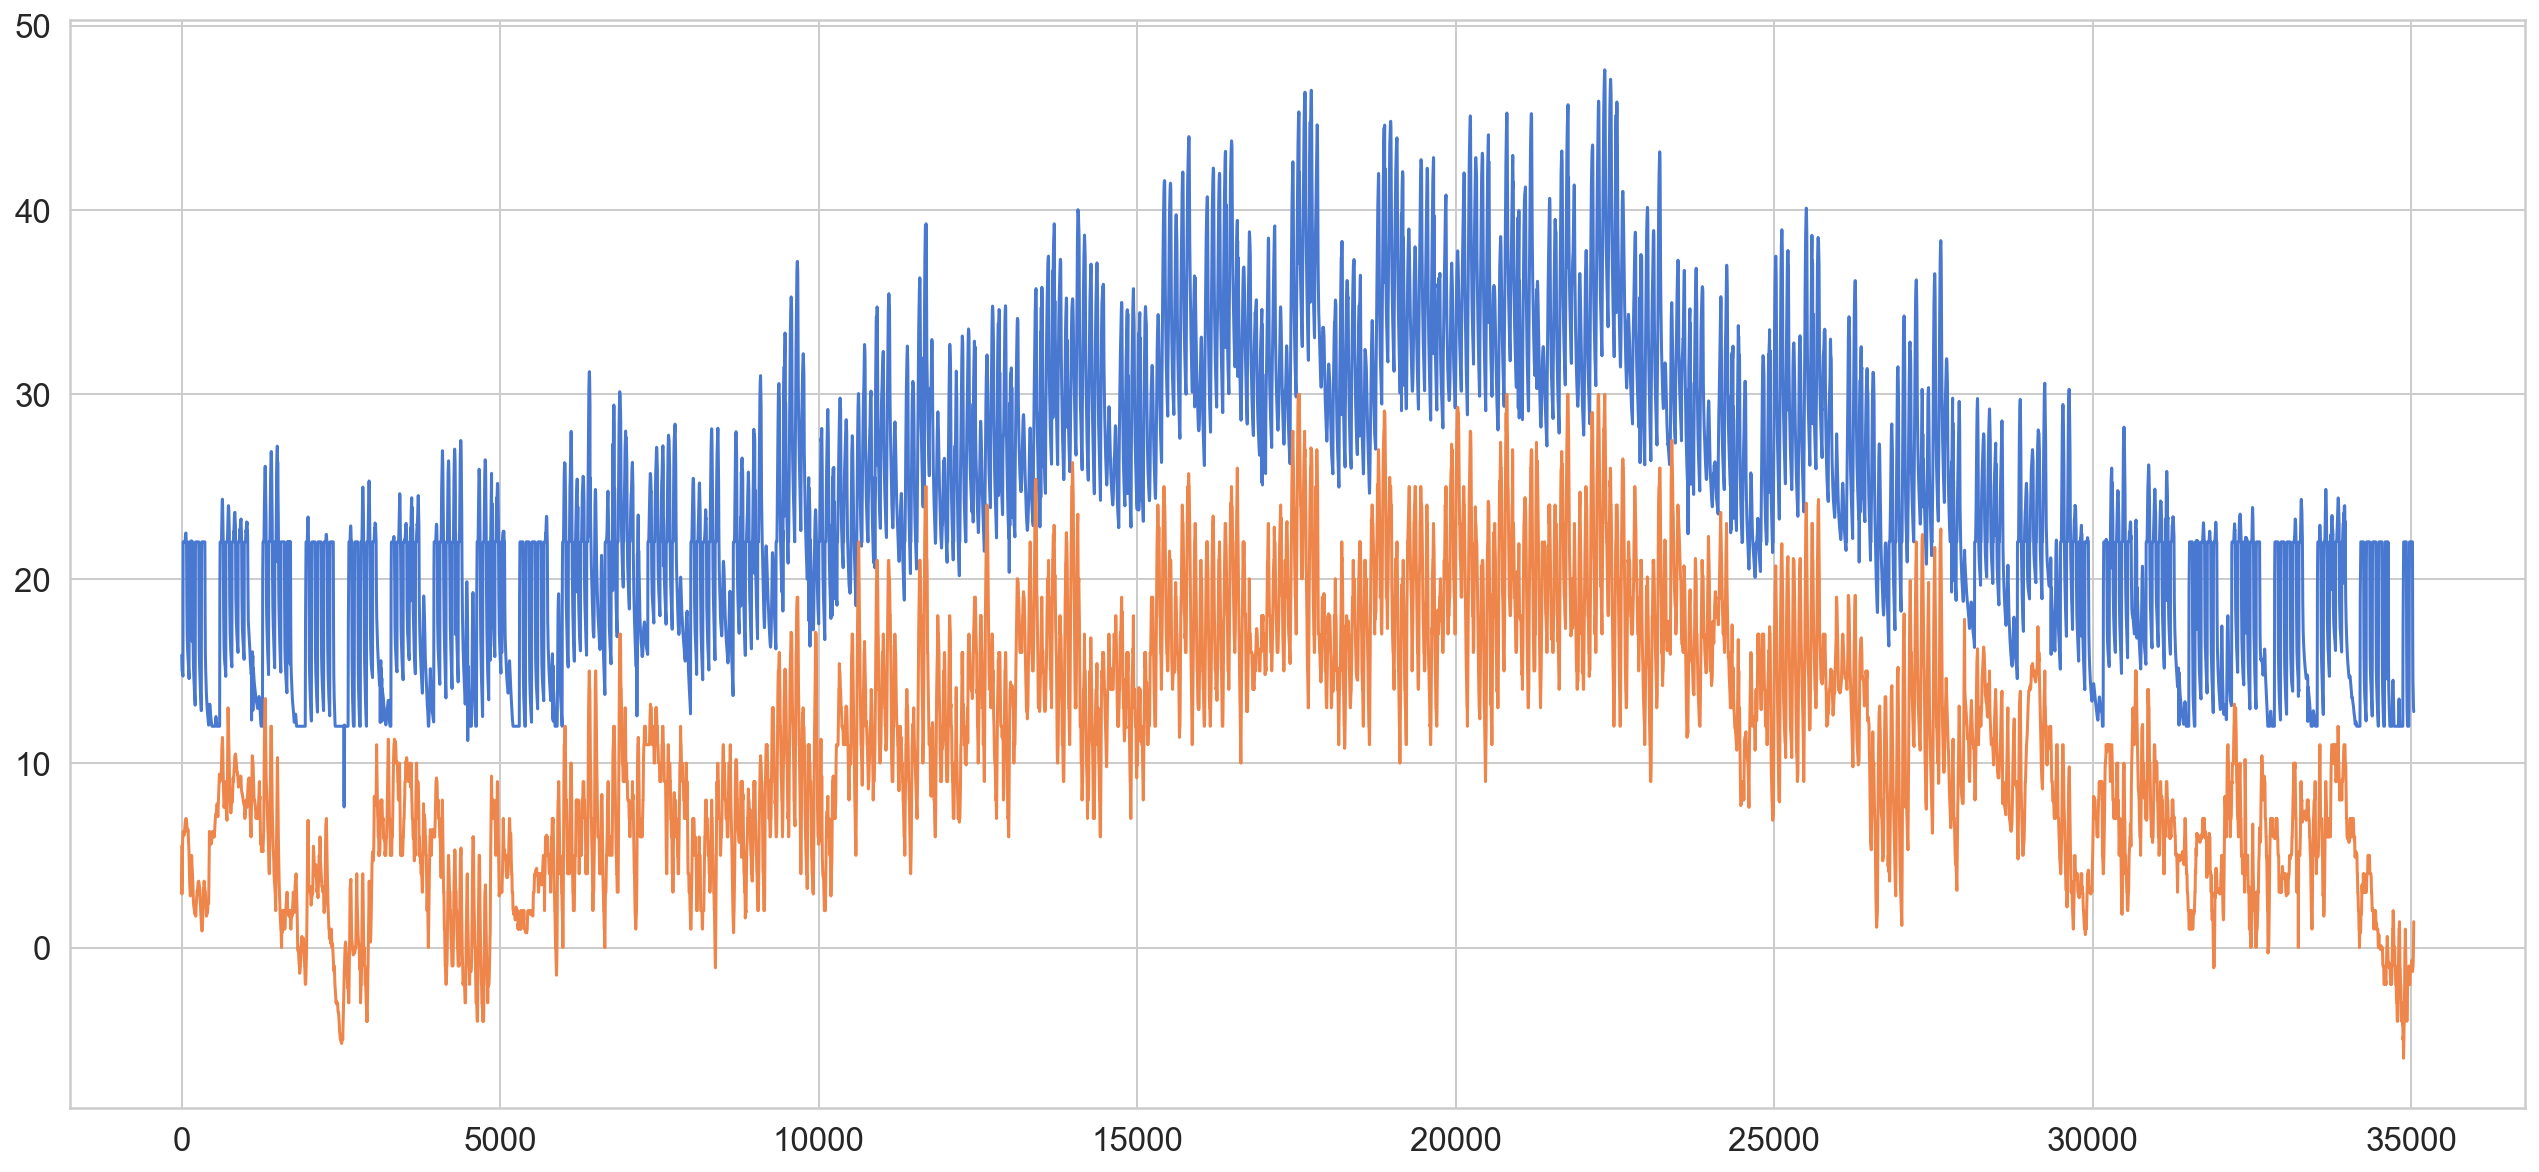

In [15]:

plt.plot(db["Température d'air"])
plt.plot(db["Température Sèche Air Extérieur"])

In [8]:
db1 = db.copy()
db1["Vent. externe"] = db1["Vent. externe"].astype(bool)
db1["Vent. externe"] = db1["Vent. externe"].astype(int)

db = db1.copy()

In [9]:
db[db["Vent. externe"] != 0]["Vent. externe"]

151      1
167      1
1097     1
1111     1
1118     1
        ..
33761    1
33935    1
33943    1
33959    1
34633    1
Name: Vent. externe, Length: 147, dtype: int32

<AxesSubplot:>

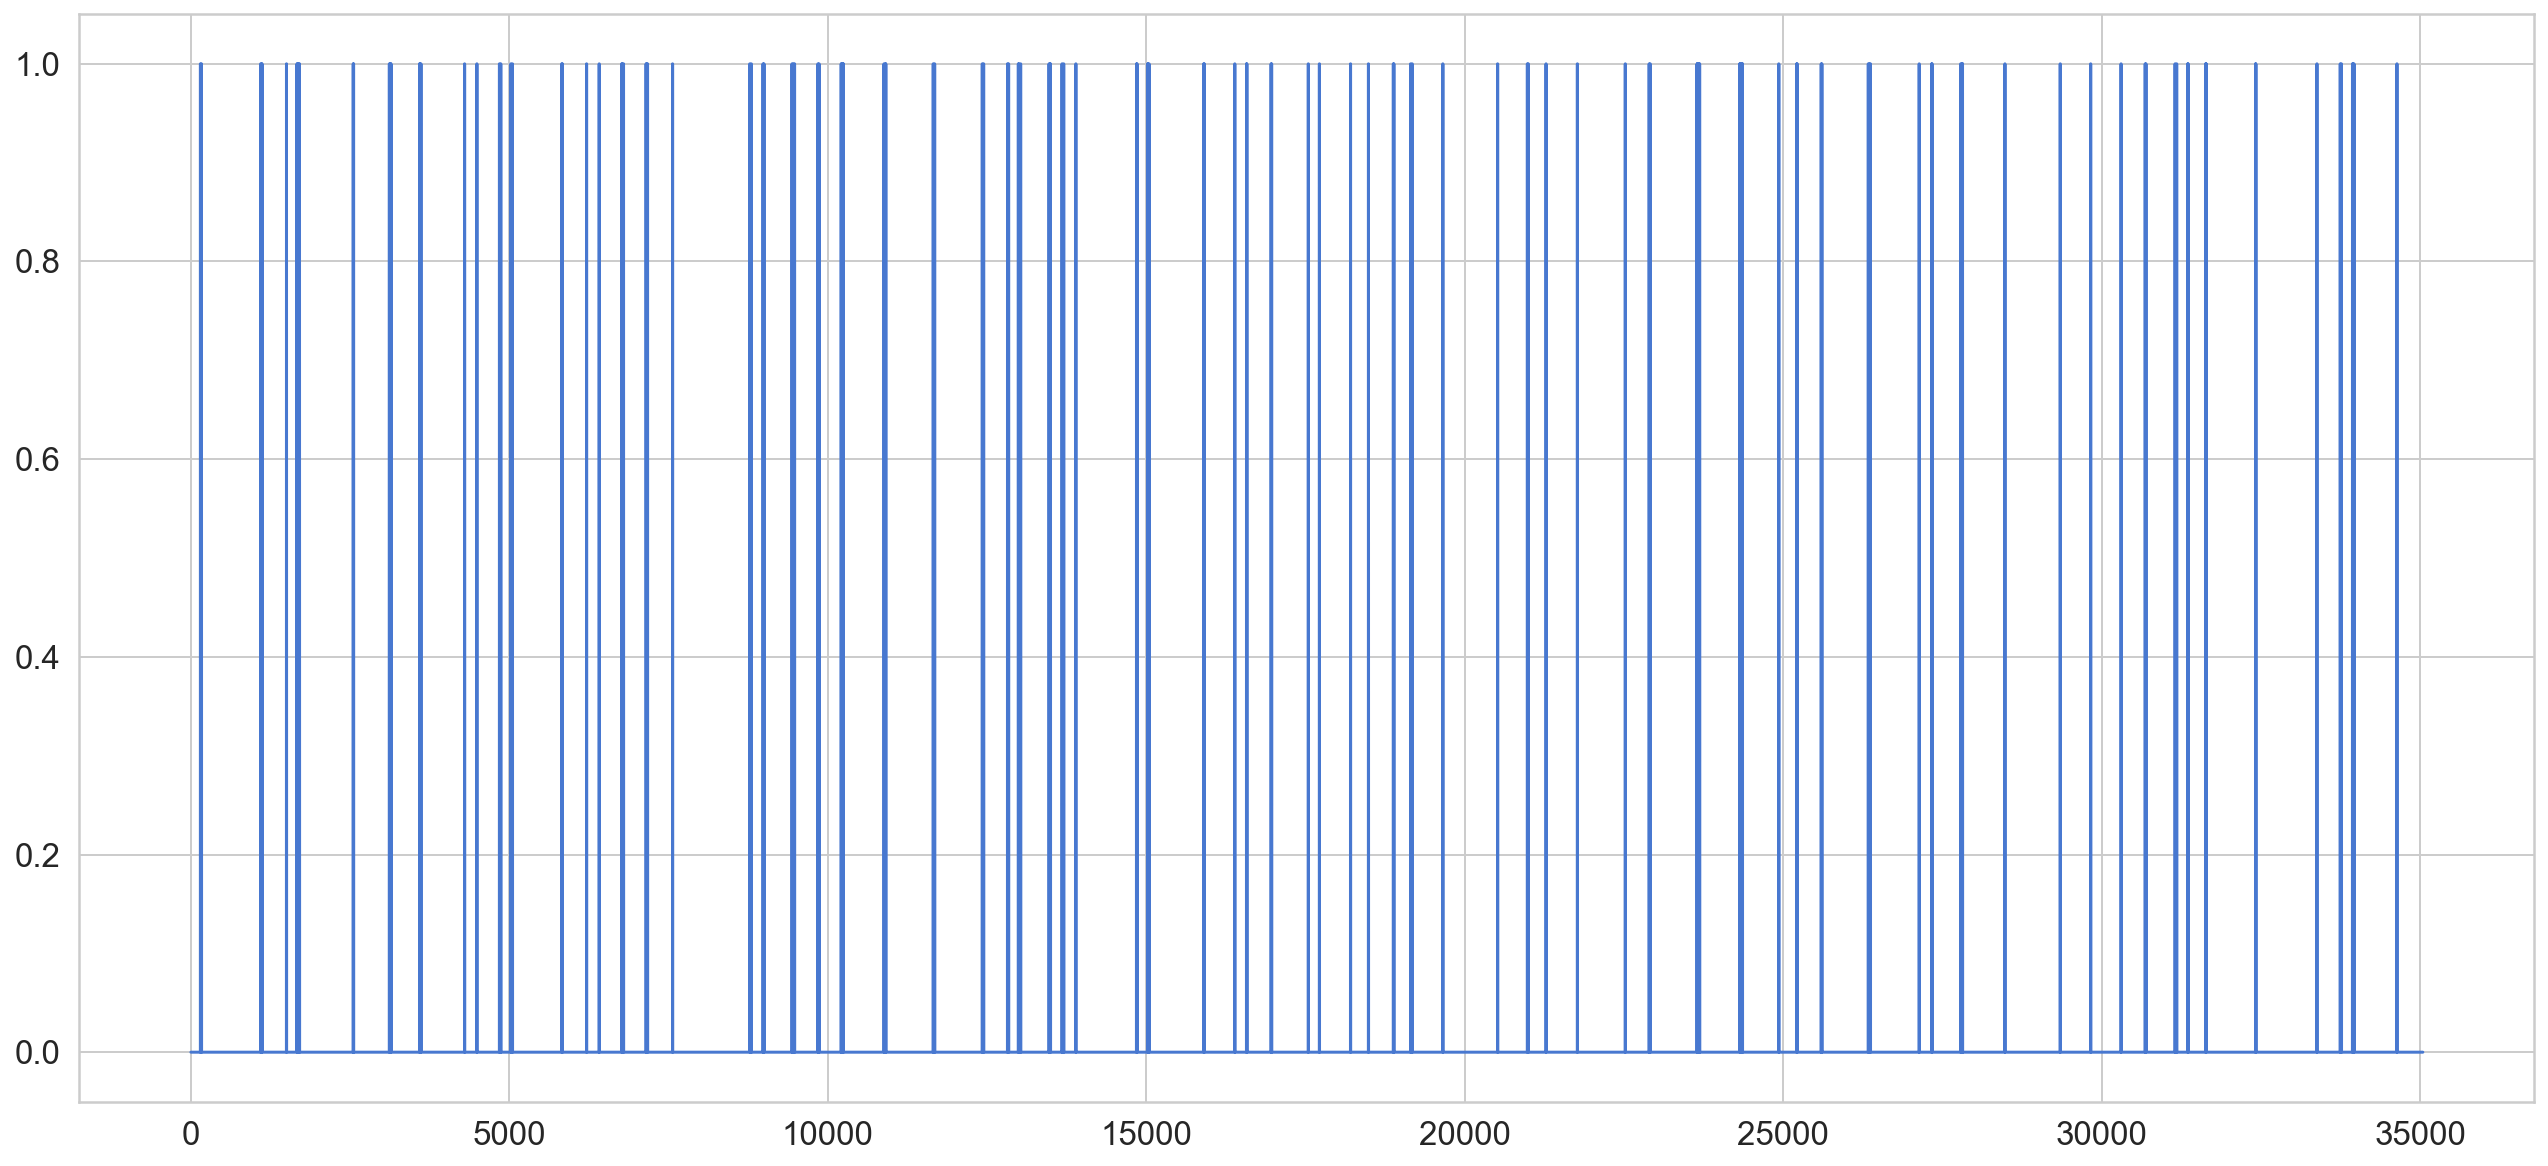

In [10]:
db["Vent. externe"].plot()

In [11]:
# X=db.drop('Vent. externe', axis=1)
# X=db.drop(["Vent. externe","Vent Méca + Vent Nat Ext + Infiltration","Apports solaires Fenêtres extérieures"] ,axis=1)
X = db.drop(["Vent. externe", "Vent Méca + Vent Nat Ext + Infiltration"], axis=1)
y = db["Vent. externe"]

In [12]:
# partitionnement des données en train & test 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

# RandomForestClassifier

In [13]:
# importation de la bibiothèque RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# construire un model random forest
# Instanciation du modèle
rf_model = RandomForestClassifier()
# entrainement du model
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
# afficher le score du modele sur les données d'entrainement
rf_model.score(X_train, y_train)

1.0

In [15]:
# afficher le score du modele sur les données de test
rf_model.score(X_test, y_test)

0.9984779299847792

In [16]:
# afficher l’importance des variables de notre modèle de forêt aléatoire
pd.DataFrame(
    rf_model.feature_importances_, index=X_train.columns, columns=["importance"]
).sort_values("importance", ascending=False)

,importance
Température d'air,0.276118
Chauffage de zone,0.235397
Température Sèche Air Extérieur,0.172828
Apports solaires Fenêtres extérieures,0.154791
Occupation,0.106451
Electricité pour la zone,0.054416


# Matrice de confusion snas le GridSearchCV

In [17]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, rf_model.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10465,0
WindowsOpen_data,16,31


In [18]:
from sklearn import metrics

y_pred = rf_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99847343, 1.        ]),
 array([1.        , 0.65957447]),
 array([0.99923613, 0.79487179]),
 array([10465,    47], dtype=int64))

# Réglage des hyperparamètres de Random Forest à l'aide de GridSearchCV¶.

In [108]:
# un dictionnaire de paramètres à tester
param_grid = { 
    'n_estimators': [100, 200,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [20,50,100,200,300,500],
    'criterion' :['gini', 'entropy']
}

In [109]:
# tester la grille des parametres 
from sklearn.model_selection import GridSearchCV
# construire un model random forest
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier()
CV_rf_model = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv= 5) # 
CV_rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 50, 100, 200, 300, 500],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]})

In [110]:
CV_rf_model.best_params_

{'criterion': 'entropy',
 'max_depth': 100,
 'max_features': 'log2',
 'n_estimators': 300}

In [59]:
rfc1 = RandomForestClassifier(
    max_features="log2", n_estimators=300, max_depth=100, criterion="entropy"
)

<IPython.core.display.Javascript object>

In [60]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, max_features='log2',
                       n_estimators=300)

<IPython.core.display.Javascript object>

# Matrice de confusion avec le GridSearchCV¶

In [61]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, rfc1.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10456,9
WindowsOpen_data,10,37


<IPython.core.display.Javascript object>

In [62]:
from sklearn import metrics

y_pred = rfc1.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99904453, 0.80434783]),
 array([0.99913999, 0.78723404]),
 array([0.99909226, 0.79569892]),
 array([10465,    47], dtype=int64))

<IPython.core.display.Javascript object>

## Learning curve

In [40]:
from sklearn.model_selection import learning_curve

[  390  4688  8986 13283 17581 21879 26176 30474 34772 39070]


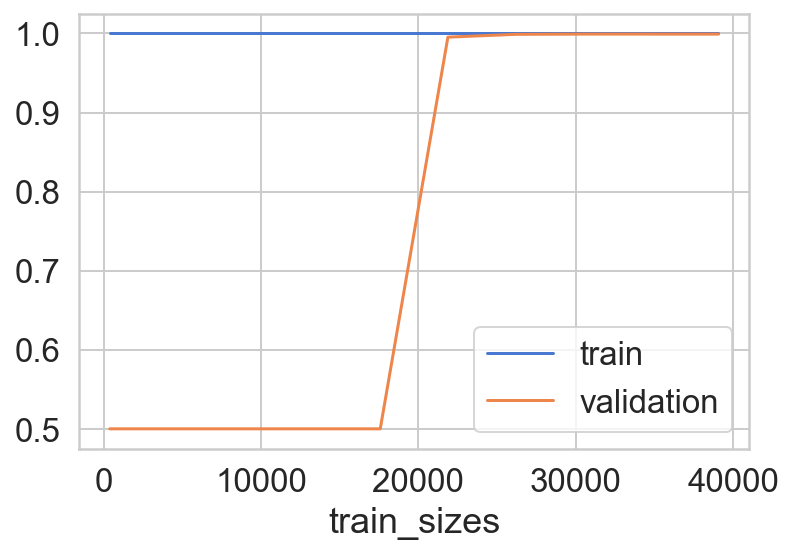

<IPython.core.display.Javascript object>

In [171]:
N, train_score, val_score = learning_curve(
    rfc1, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 10), cv=5
)
print(N)
plt.plot(N, train_score.mean(axis=1), label="train")
plt.plot(N, val_score.mean(axis=1), label="validation")
plt.xlabel("train_sizes")
plt.legend()

Text(0.5, 0, 'train_sizes')

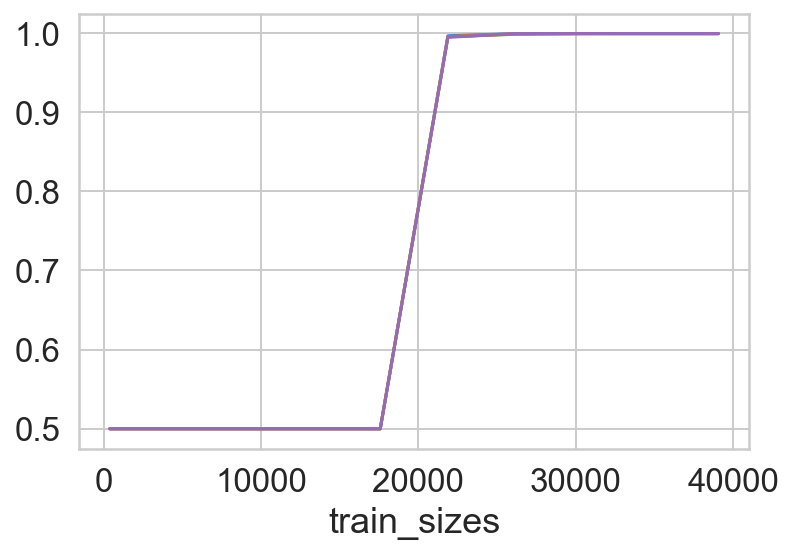

<IPython.core.display.Javascript object>

In [172]:
plt.plot(N, val_score,label='validation')
plt.xlabel('train_sizes')


In [173]:
X

,Chauffage de zone,Occupation,Apports solaires Fenêtres extérieures,Température d'air,Electricité pour la zone,Température Sèche Air Extérieur
1,0.0,0.0,0.0,15.85499,0.114429,5.525
2,0.0,0.0,0.0,15.65203,0.114429,4.650
3,0.0,0.0,0.0,15.42231,0.114429,3.775
4,0.0,0.0,0.0,15.19036,0.114429,2.900
5,0.0,0.0,0.0,15.06030,0.114429,3.250
...,...,...,...,...,...,...
35036,0.0,0.0,0.0,13.01602,0.114429,0.100
35037,0.0,0.0,0.0,12.94014,0.114429,0.425
35038,0.0,0.0,0.0,12.88162,0.114429,0.750
35039,0.0,0.0,0.0,12.83418,0.114429,1.075


<IPython.core.display.Javascript object>

# AdaBoostClassifier

In [63]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf_AdaBoost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(), learning_rate=0.001, n_estimators=500
)
clf_AdaBoost.fit(X_train, y_train)
clf_AdaBoost.score(X_test, y_test)

0.9968607305936074

<IPython.core.display.Javascript object>

In [64]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, clf_AdaBoost.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10441,24
WindowsOpen_data,9,38


<IPython.core.display.Javascript object>

In [65]:
from sklearn import metrics

y_pred = clf_AdaBoost.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99913876, 0.61290323]),
 array([0.99770664, 0.80851064]),
 array([0.99842219, 0.69724771]),
 array([10465,    47], dtype=int64))

<IPython.core.display.Javascript object>

In [96]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}
gs = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), params)
gs.fit(X_train,y_train)
print(gs.best_estimator_)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.1,
                   n_estimators=1000)


In [66]:
clf_AdaBoost1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=0.001,
                   n_estimators=500 )
clf_AdaBoost1.fit(X_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.001,
                   n_estimators=500)

<IPython.core.display.Javascript object>

In [67]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, clf_AdaBoost1.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10440,25
WindowsOpen_data,9,38


<IPython.core.display.Javascript object>

In [68]:
from sklearn import metrics

y_pred = clf_AdaBoost1.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99913867, 0.6031746 ]),
 array([0.99761108, 0.80851064]),
 array([0.99837429, 0.69090909]),
 array([10465,    47], dtype=int64))

<IPython.core.display.Javascript object>

# GradientBoostingClassifier

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
clf_GradientBoosting = GradientBoostingClassifier(n_estimators=700,
    learning_rate=0.15, loss="deviance", max_depth=8, random_state=0,
    max_features="sqrt", min_samples_leaf=0.1, min_samples_split=0.2,
    subsample=0.9, criterion="friedman_mse")
clf_GradientBoosting.fit(X_train, y_train)
clf_GradientBoosting.score(X_test, y_test)


0.994482496194825

<IPython.core.display.Javascript object>

In [70]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, clf_GradientBoosting.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10418,47
WindowsOpen_data,11,36


<IPython.core.display.Javascript object>

In [71]:
from sklearn import metrics

y_pred = clf_GradientBoosting.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99894525, 0.43373494]),
 array([0.99550884, 0.76595745]),
 array([0.99722408, 0.55384615]),
 array([10465,    47], dtype=int64))

<IPython.core.display.Javascript object>

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 5),
    "min_samples_leaf": np.linspace(0.1, 0.5, 5),
    "max_depth":[8,10],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.9, 0.95, 1.0],
    "n_estimators":[500,600,700]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)

clf.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'mae'],
                         'learning_rate': [0.1, 0.15, 0.2],
                         'loss': ['deviance'], 'max_depth': [8, 10],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'n_estimators': [500, 600, 700],
                         'subsample': [0.9, 0.95, 1.0]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [130]:
clf

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'mae'],
                         'learning_rate': [0.1, 0.15, 0.2],
                         'loss': ['deviance'], 'max_depth': [8, 10],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'n_estimators': [500, 600, 700],
                         'subsample': [0.9, 0.95, 1.0]},
             refit=False,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [131]:
df_Gboosting=pd.DataFrame.from_dict(clf.cv_results_)

In [132]:
#find the best parameter based on the accuracy_score
#taking the average of the accuracy_score
df_Gboosting['accuracy_score']=(df_Gboosting['split0_test_accuracy']+df_Gboosting['split1_test_accuracy'])/2

df_Gboosting.loc[df_Gboosting['accuracy_score'].idxmax()]['params']

{'criterion': 'friedman_mse',
 'learning_rate': 0.15,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.2,
 'n_estimators': 700,
 'subsample': 0.9}

In [72]:
clf_GradientBoosting_Best = GradientBoostingClassifier(
    n_estimators=700,
    learning_rate=0.15,
    loss="deviance",
    max_depth=8,
    random_state=0,
    max_features="sqrt",
    min_samples_leaf=0.1,
    min_samples_split=0.2,
    subsample=0.9,
    criterion="friedman_mse",
)

<IPython.core.display.Javascript object>

clf_GradientBoosting_Best = GradientBoostingClassifier(n_estimators=600, learning_rate=0.2, 
                                                       loss='deviance',max_depth=5, random_state=0, max_features='sqrt',
                                                       min_samples_leaf=0.1,min_samples_split=0.31818181818181823,
                                                       subsample= 1.0)

In [73]:
clf_GradientBoosting_Best.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.15, max_depth=8, max_features='sqrt',
                           min_samples_leaf=0.1, min_samples_split=0.2,
                           n_estimators=700, random_state=0, subsample=0.9)

<IPython.core.display.Javascript object>

In [74]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, clf_GradientBoosting_Best.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10418,47
WindowsOpen_data,11,36


<IPython.core.display.Javascript object>

In [75]:
from sklearn import metrics

y_pred = clf_GradientBoosting_Best.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99894525, 0.43373494]),
 array([0.99550884, 0.76595745]),
 array([0.99722408, 0.55384615]),
 array([10465,    47], dtype=int64))

<IPython.core.display.Javascript object>

# DecisionTreeClassifier

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
clf_tree = DecisionTreeClassifier(
    max_features="log2", max_depth=500, criterion="entropy"
)
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.997431506849315

<IPython.core.display.Javascript object>

In [77]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, clf_tree.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10448,17
WindowsOpen_data,10,37


<IPython.core.display.Javascript object>

In [78]:
from sklearn import metrics

y_pred = clf_tree.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99904379, 0.68518519]),
 array([0.99837554, 0.78723404]),
 array([0.99870955, 0.73267327]),
 array([10465,    47], dtype=int64))

<IPython.core.display.Javascript object>

In [59]:
from sklearn.model_selection import GridSearchCV

tree_para = {"criterion": ["gini", "entropy"], "max_depth": [500, 600, 700]}
clf_Dtree = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf_Dtree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [500, 600, 700]})

In [60]:
Dtree_best = clf_Dtree.best_estimator_
Dtree_best.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=600)

In [61]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, Dtree_best.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10461,3
WindowsOpen_data,8,40


In [62]:
from sklearn import metrics

y_pred = Dtree_best.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99923584, 0.93023256]),
 array([0.9997133 , 0.83333333]),
 array([0.99947451, 0.87912088]),
 array([10464,    48], dtype=int64))

# SVM

In [79]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svc_model = make_pipeline(StandardScaler(), SVC(C=100, gamma=0.1))
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, gamma=0.1))])

<IPython.core.display.Javascript object>

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)

In [40]:
X_train_sc

array([[-0.28058175, -0.51258151, -0.66325707, -1.18718502, -0.78955891,
        -1.45680752],
       [ 1.15410519,  2.96106722, -0.30939304, -0.38400698,  1.26652994,
        -0.7114265 ],
       [ 5.17406531, -0.51258151, -0.66325707, -0.40609288, -0.78955891,
        -1.32292841],
       ...,
       [-0.28058175, -0.51258151, -0.66325707, -0.5988804 , -0.78955891,
        -0.45452333],
       [-0.28058175,  0.8286632 ,  0.78286621,  0.56706918,  1.26652994,
         0.41388175],
       [-0.28058175, -0.51258151, -0.3402674 ,  1.0767249 , -0.78955891,
         1.17373619]])

In [41]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 0.1, 1, 10, 100], 
              'gamma': [1000,100, 10, 1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = -3)
  
# fitting the model for grid search
grid.fit(X_train_sc, y_train)

KeyboardInterrupt: 

In [75]:
grid.best_estimator_

SVC(C=100, gamma=0.1)

In [80]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, svc_model.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10419,46
WindowsOpen_data,3,44


<IPython.core.display.Javascript object>

In [81]:
from sklearn import metrics

y_pred = svc_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99971215, 0.48888889]),
 array([0.9956044 , 0.93617021]),
 array([0.99765404, 0.64233577]),
 array([10465,    47], dtype=int64))

<IPython.core.display.Javascript object>

# KNN

In [82]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=1)
KNN_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

<IPython.core.display.Javascript object>

In [83]:
KNN_model.score(X_test, y_test)

0.9988584474885844

<IPython.core.display.Javascript object>

In [84]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, KNN_model.predict(X_test)),
    index=["WindowsClose_data", "WindowsOpen_data"],
    columns=["WindowsClose_predit", "WindowsOpen_predit"],
)

,WindowsClose_predit,WindowsOpen_predit
WindowsClose_data,10458,7
WindowsOpen_data,5,42


<IPython.core.display.Javascript object>

In [85]:
from sklearn import metrics

y_pred = KNN_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.99952213, 0.85714286]),
 array([0.9993311 , 0.89361702]),
 array([0.99942661, 0.875     ]),
 array([10465,    47], dtype=int64))

<IPython.core.display.Javascript object>

In [86]:
np.linspace(0.1, 0.5, 5)

array([0.1, 0.2, 0.3, 0.4, 0.5])

<IPython.core.display.Javascript object>

# Smote

In [154]:
#!pip install nb_black

In [51]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
import time

%matplotlib inline

<IPython.core.display.Javascript object>

In [52]:
from collections import Counter

counter = Counter(y_train)
for k, v in counter.items():
    dist = v / len(y_train) * 100
    print(f"Class={k}, n={v} ({dist}%)")

Class=0, n=24428 (99.59230267449446%)
Class=1, n=100 (0.40769732550554466%)


<IPython.core.display.Javascript object>

<BarContainer object of 2 artists>

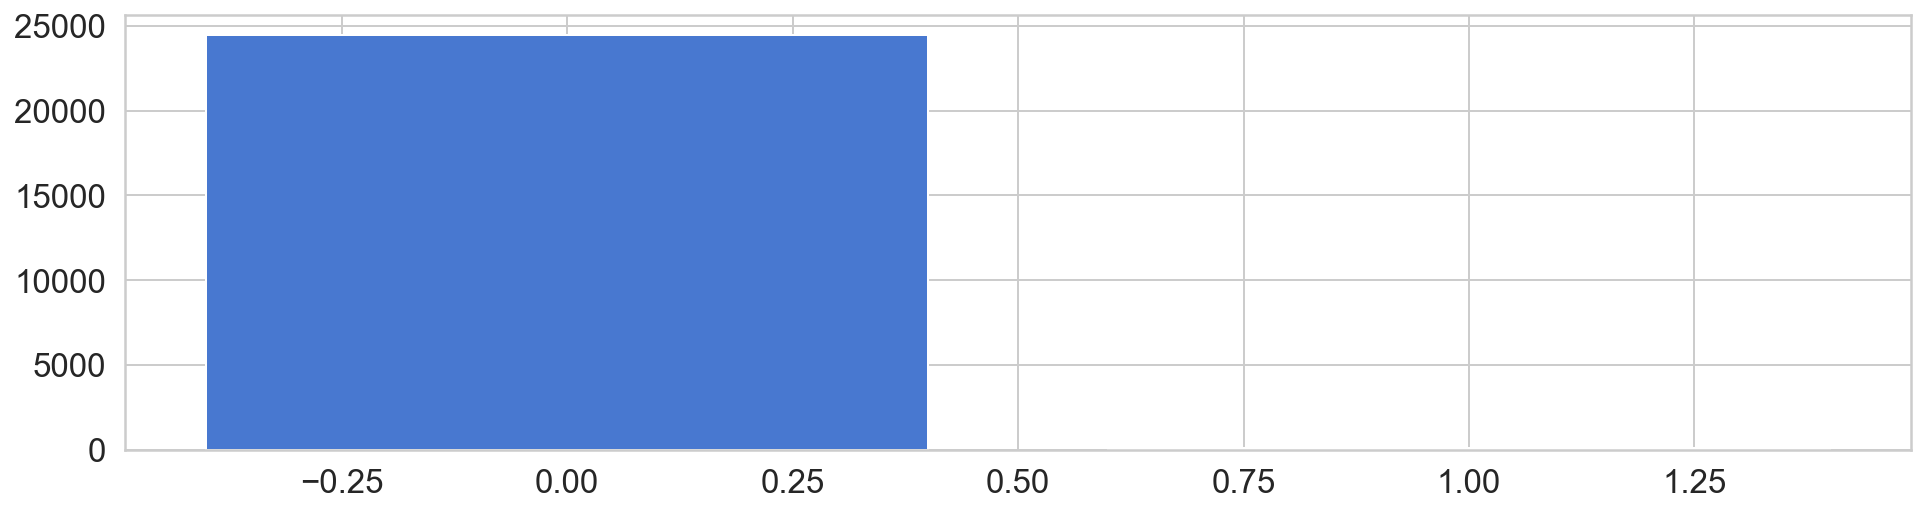

<IPython.core.display.Javascript object>

In [53]:
plt.figure(1, figsize=(16, 4))
plt.bar(counter.keys(), counter.values())

In [54]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

oversample = SMOTE()
undersample = RandomUnderSampler()
steps = [("o", oversample), ("u", undersample)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [55]:
counter = Counter(y_train)
for k, v in counter.items():
    dist = v / len(y_train) * 100
    print(f"Class={k}, n={v} ({dist}%)")

Class=0, n=24428 (50.0%)
Class=1, n=24428 (50.0%)


<IPython.core.display.Javascript object>